# Environment Preparation

# 0 - Imports

In [49]:
#Extração
from sqlalchemy             import create_engine


#plot e manipulação
import pandas            as pd
import numpy             as np
from   scipy             import stats
import seaborn           as sns
import scikitplot        as skplt
import matplotlib.pyplot as plt
import pickle

#display
import sweetviz               as sv
from tabulate                 import tabulate
from IPython.core.display     import HTML
from IPython.display          import Image

#Preparação
from sklearn import ensemble        as en
from sklearn import model_selection as ms
from sklearn import preprocessing   as pp

import warnings

warnings.filterwarnings('ignore')

from credenciais import chave

#Credenciais Database:
host = chave.get('host')
port = chave.get('port')
Database =chave.get('Database')
user = chave.get('user')
password = chave.get('password')

## Functions

In [50]:
def jupyter_settings():
    """ Optimize general settings, standardize plot sizes, etc. """
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 20
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)
jupyter_settings()

#Connect Database
def create_server_connection(user, password, host, port, database):
    connection = None #Encerrar qualquer conexão existente
    try:
        connection = pg.connect( user=user,
            password=password,
            host=host,
            port= port,
            database=database)

        print('Database Connection Successful')
    except Error as err:
        print(f"Error: '{err}'")

    return connection

#Close Connection Database
def close_function(con):
    return con.close()


#Calculo das estatisticas simples
def calcula_estatistica(data):

    #Central Tendency - mean - median - moda
    mean= round(np.mean(data),2)
    mode= round(stats.mode(data,)[0][0],2)
    median=round(np.median(data),2)
    
    
    var= round(np.var(data),2)
    std= round(np.std(data),2)
    coef_person= round(stats.skew(data),2)
    corf_kurtosis= round(kurtosis(data),2)
    msg= print('Media: {} \nModa: {}\nMediana: {}\nVariância: {}\nDesvio Padrão: {}\nSkew: {}\n Kurtosis: {}'.format(mean, mode, median, var, std, coef_person, corf_kurtosis))

    return msg
#Calculo das estatisticas mais completa

def calcula_estatistica1(atributes):
    #Central Tendency - mean - median
    ct1 = pd.DataFrame(atributes.apply(np.mean)).T
    ct2 = pd.DataFrame(atributes.apply(np.median)).T
    ct3 = pd.DataFrame(atributes.apply(lambda x: round(stats.mode(x,)[0][0],2))).T

    #Dispersion - STD, min, max, range, sken, Kurtosis
    d1 = pd.DataFrame(atributes.apply(np.std)).T
    d2 = pd.DataFrame(atributes.apply(min)).T
    d3 = pd.DataFrame(atributes.apply(max)).T
    d4 = pd.DataFrame(atributes.apply(lambda x: x.max() - x.min() )).T
    d5 = pd.DataFrame(atributes.apply(lambda x: x.skew() )).T
    d6 = pd.DataFrame(atributes.apply(lambda x: x.kurtosis() )).T

    #Concatenate

    m = pd.concat([d2, d3, d4, ct1, ct2, ct3, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median','moda', 'std', 'skew', 'kurtosis']
    return m

#Function Calculates cramer V
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - ( k - 1 ) * ( r - 1) / (n - 1))
    kcorr = k - (k - 1) **2/(n - 1) 
    rcorr = r - (r - 1) **2/(n - 1)
    
    return np.sqrt( (chi2corr / n) / (min(kcorr -1, rcorr -1) ) )

# Funçoes que avalia a performance dos modelos

#Precision at K
def precision_at_k(data,yhat_model, k=2000):

    #propensity score
    data['score'] = yhat_model[:, 1].tolist()

    #Sorte clients by propensity score
    data = data.sort_values(by='score', ascending=False)

    #Reset index
    data = data.reset_index(drop=True)

    #create ranking order
    data['ranking'] = data.index + 1 #Criando um ranking

    data['precision_at_K'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_K']

#Recall at_K
def recall_at_k(data,yhat_model, k=2000):

    #propensity score
    data['score'] = yhat_model[:, 1].tolist()

    #Sorte clients by propensity score
    data = data.sort_values(by='score', ascending=False)

    #Reset index
    data = data.reset_index(drop=True)

    #create ranking order
    data['ranking'] = data.index + 1 #Criando um ranking

    data['recall_at_K'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_K']

# 1 - Descrição dos dados

| Coluna | Tradução | Descrição
| :----- | --------: |--------: | 
| gender | Gênero sexual | gênero do cliente.
| age | idade | idade do cliente.
| region code | Código Regional | código da região do cliente.
| policy sales channel | canal de vendas da política | código anônimo para o canal de contato com o cliente.
| driving license | carteira de motorista | 0, o cliente não tem permissão para dirigir e 1, o cliente tem para dirigir ( CNH – Carteira Nacional de Habilitação )
| vehicle age | idade do veículo | idade do veículo.
| vehicle damage | danos no veículo | 0, cliente nunca teve seu veículo danificado no passado e 1, cliente já teve seu veículo danificado no passado.
| previsiously insured | previamente segurado | 0, o cliente não tem seguro de automóvel e 1, o cliente já tem seguro de automóvel.
| annuall premium | prêmio anual | quantidade que o cliente pagou à empresa pelo seguro de saúde anual.
| vintage | Vigencia em dias | número de dias que o cliente se associou à empresa através da compra do seguro de saúde.
| response | Variavel Resposta | 0, o cliente não tem interesse e 1, o cliente tem interesse.


In [51]:
df = pd.read_csv('/home/wellington/Documentos/Projetos/Projetos_ds_pa/health-insurance-cross-sell.pa04/data/data_collection_done.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [52]:
df.head(3)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1


## Data Dimensions

In [53]:
print('Number of Rows {}'.format(df.shape[0]))
print('Number of Cols {}'.format(df.shape[1]))

Number of Rows 381109
Number of Cols 12


## Data Types

## Check NA

In [54]:
df.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

In [55]:
df.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## Descriptive Statistical

In [56]:
num_atributes = df.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df[['gender','region_code','policy_sales_channel', 'driving_license', 'vehicle_age', 'vehicle_damage', 'previously_insured', 'response']]

In [57]:
calcula_estatistica1(num_atributes)

,attributes,min,max,range,mean,median,moda,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,1.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,24.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,152.0,54.203924,-9.000081e-01,-0.970810
4,driving_license,0.0,1.0,1.0,0.997869,1.0,1.0,0.046109,-2.159518e+01,464.354302
5,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.0,0.498251,1.677471e-01,-1.971871
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,2630.0,17213.132474,1.766087e+00,34.004569
7,vintage,10.0,299.0,289.0,154.347397,154.0,256.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.0,0.327935,2.301906e+00,3.298788


### Num attributes plot

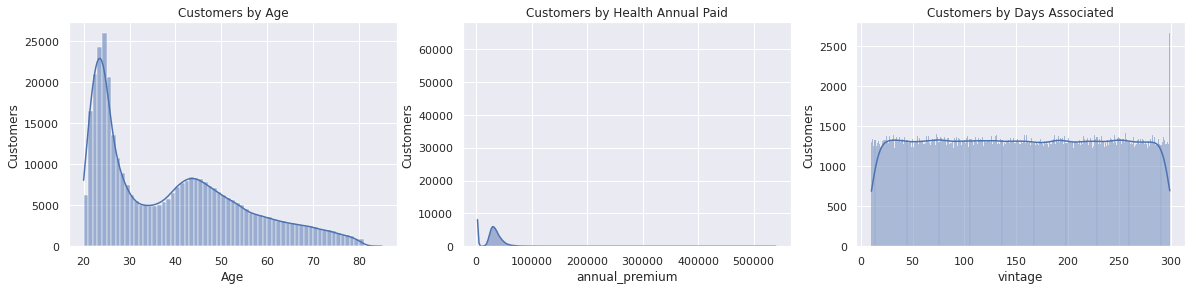

In [58]:
plt.figure(figsize=(20,14))

plt.subplot(3,3,1)
age_hist = sns.histplot(df['age'], binwidth=1, kde=True);
age_hist.set_ylabel('Customers')
age_hist.set_xlabel('Age')
age_hist.set_title('Customers by Age');

plt.subplot(3,3,2)
hap_hist = sns.histplot(df['annual_premium'], kde=True);
hap_hist.set_ylabel('Customers')
hap_hist.set_xlabel('annual_premium')
hap_hist.set_title('Customers by Health Annual Paid');

plt.subplot(3,3,3)
da_hist = sns.histplot(df['vintage'], binwidth=1, kde=True);
da_hist.set_ylabel('Customers')
da_hist.set_xlabel('vintage')
da_hist.set_title('Customers by Days Associated');

## Categorical Atributes

In [59]:
print(cat_attributes.apply(lambda x: x.unique().shape[0]))
print(f"- Variations:\n{cat_attributes.apply( lambda x: x.unique() ) } " )

gender                    2
region_code              53
policy_sales_channel    155
driving_license           2
vehicle_age               3
vehicle_damage            2
previously_insured        2
response                  2
dtype: int64
- Variations:
gender                                                     [Male, Female]
region_code             [28.0, 3.0, 11.0, 41.0, 33.0, 6.0, 35.0, 50.0,...
policy_sales_channel    [26.0, 152.0, 160.0, 124.0, 14.0, 13.0, 30.0, ...
driving_license                                                    [1, 0]
vehicle_age                               [> 2 Years, 1-2 Year, < 1 Year]
vehicle_damage                                                  [Yes, No]
previously_insured                                                 [0, 1]
response                                                           [1, 0]
dtype: object 


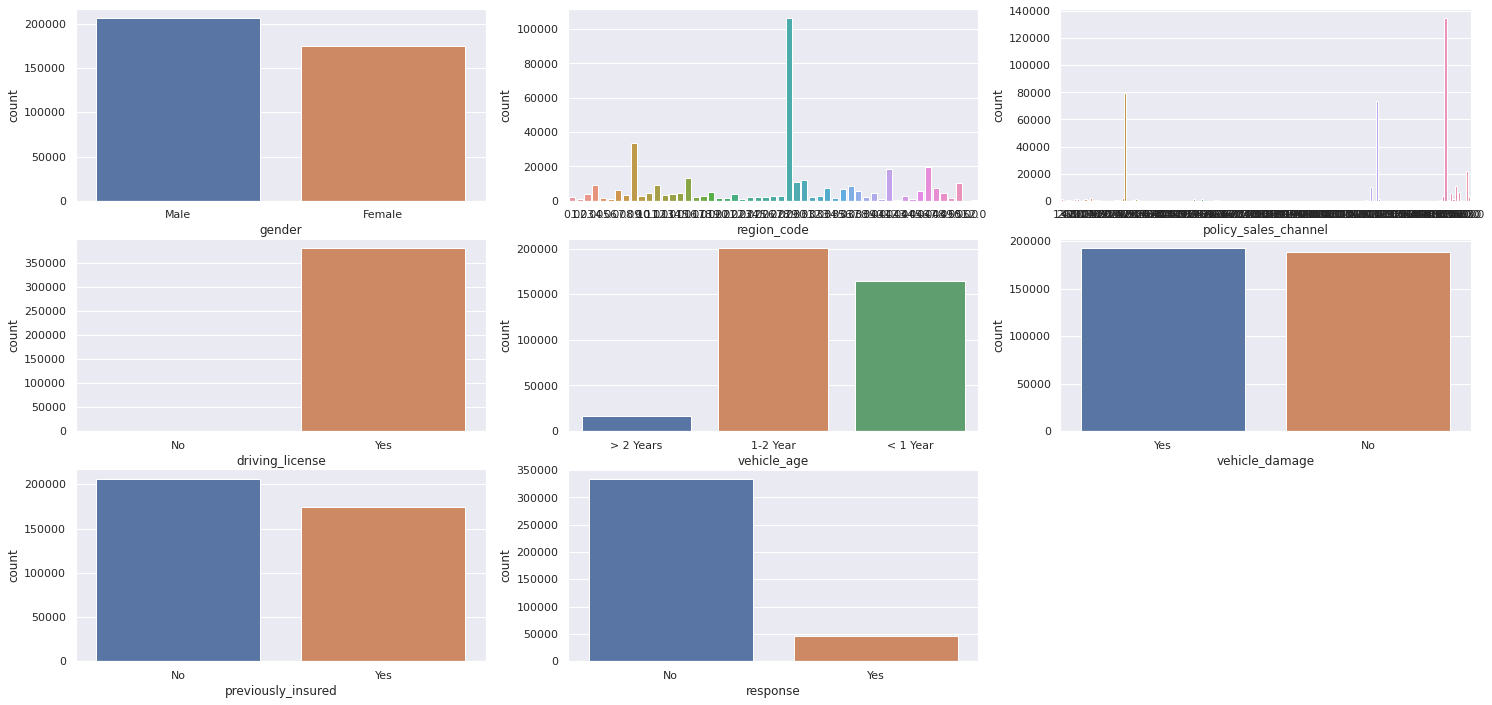

In [60]:
plt.figure(figsize=(25,12))

plt.subplot (3,3,1)
sns.countplot (x = cat_attributes['gender']);

plt.subplot (3,3,2)
sns.countplot (x = cat_attributes['region_code']);

plt.subplot (3,3,3)
sns.countplot (x = cat_attributes['policy_sales_channel']);

plt.subplot (3,3,4)
sns.countplot (x = cat_attributes['driving_license']);
plt.xticks([0,1],['No','Yes']);

plt.subplot (3,3,5)
sns.countplot (x = cat_attributes['vehicle_age']);

plt.subplot (3,3,6)
sns.countplot (x = cat_attributes['vehicle_damage']);

plt.subplot (3,3,7)
sns.countplot (x = cat_attributes['previously_insured']);
plt.xticks([0,1],['No','Yes']);

plt.subplot (3,3,8)
sns.countplot (x = cat_attributes['response']);
plt.xticks([0,1],['No','Yes']);

In [61]:
round(cat_attributes['response'].value_counts(normalize=True) * 100 ,2)

0    87.74
1    12.26
Name: response, dtype: float64

### Test Data Extraction

In [62]:
df1 = df.copy()

In [63]:
df1.head(1)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1


In [64]:
#Test dataset extration
X = df1.drop('response', axis=1).copy()
y = df1['response'].copy()

x_train, x_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.20, random_state=45)

#df2 is the new dataset, and will be used to train and validate the models
df2 = pd.concat([x_train, y_train], axis=1)

#df_test is a separate dataset, and will be used to perfomr the final evaluetion of the trained model
df_test = pd.concat([x_test, y_test], axis=1)

In [65]:
df1.head(10)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0
5,6,Female,24,33.0,160.0,1,< 1 Year,Yes,0,2630.0,176,0
6,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
7,8,Female,56,28.0,26.0,1,1-2 Year,Yes,0,32031.0,72,1
8,9,Female,24,3.0,152.0,1,< 1 Year,No,1,27619.0,28,0
9,10,Female,32,6.0,152.0,1,< 1 Year,No,1,28771.0,80,0


In [66]:
#Check test stratify
df_test['response'].value_counts() / df_test['response'].count()

0    0.877371
1    0.122629
Name: response, dtype: float64

In [67]:
df_test.shape

(76222, 12)

In [68]:
df_test.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

In [69]:
#Check train stratify
df2['response'].value_counts() / df2['response'].count() 

0    0.877453
1    0.122547
Name: response, dtype: float64

In [70]:
df2.shape

(304887, 12)

In [71]:
df2.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

In [72]:
#Save datasets
df2.to_csv('/home/wellington/Documentos/Projetos/Projetos_ds_pa/health-insurance-cross-sell.pa04/data/df2_data_description.csv', index=False)
df_test.to_csv('/home/wellington/Documentos/Projetos/Projetos_ds_pa/health-insurance-cross-sell.pa04/data/test_full_data.csv', index=False)

# 2 - Feature Engineering

In [73]:
df3 = pd.read_csv('/home/wellington/Documentos/Projetos/Projetos_ds_pa/health-insurance-cross-sell.pa04/data/df2_data_description.csv')

In [74]:
df3.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,21908,Female,22,22.0,152.0,1,< 1 Year,Yes,0,41632.0,87,0
1,84580,Male,22,2.0,152.0,1,< 1 Year,Yes,0,2630.0,147,0
2,223179,Male,66,28.0,124.0,1,1-2 Year,No,1,34524.0,216,0
3,224406,Female,23,23.0,160.0,1,< 1 Year,No,1,2630.0,280,0
4,296599,Male,54,28.0,26.0,1,1-2 Year,No,1,64831.0,64,0


## Mapa Mental de Hipóteses

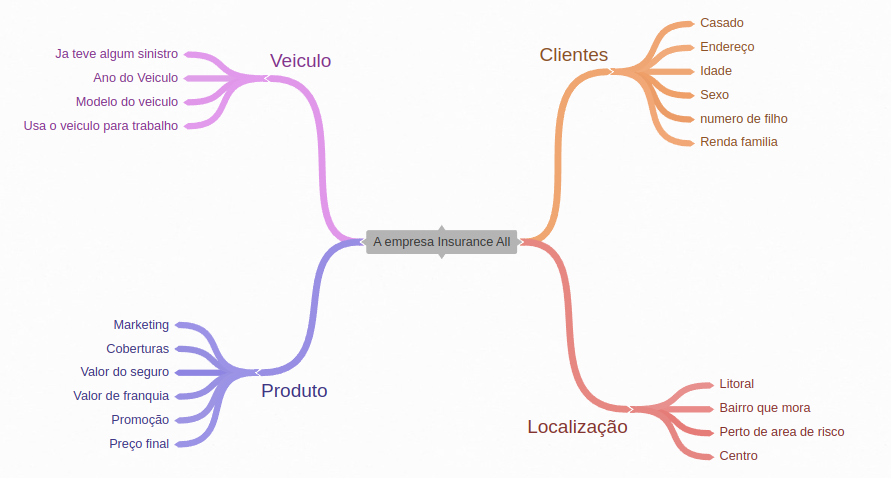

In [75]:
Image('/home/wellington/Documentos/Projetos/Projetos_ds_pa/health-insurance-cross-sell.pa04/reports/figures/mapa_mental.png', )

### Crição de Hipóteses

#### As Hipoteses Referente aos clientes

**1,** clientes com mais de 40 anos são clientes a mais de 1 ano da empresa.

**2,** 80% Dos clientes são do sexo Masculino

**3,** 80% dos clientes Habilitados são do sexo Masculino.

**4,** 80% Dos clientes que teve o carro danificado são do sexo masculino. 

**5,** Clientes acima de 40 anos tem carros mais antigos

**6,** Apenas 20% dos Clientes que ja assegurado aceitaria adquirir um novo seguro.

**7,** 70% dos Clientes que pagam acima de 10.000 pelo premium do seguro de saude aceitariam adquirir o seguro de automovel

#### As Hipoteses referente ao produto

**8,** 60% dos Clientes que danificou o carro colocou na pesquisa que tem interesse em adquirir o seguro.

**9,** Veiculos mais antigo tem 60% de chance de adquirir o seguro segundo a pesquisa



## Feature Engineering

### Columns Vehicle_age

In [76]:
df3.vehicle_age.value_counts()

1-2 Year     160373
< 1 Year     131691
> 2 Years     12823
Name: vehicle_age, dtype: int64

In [77]:
dict_vehicle_age = {'> 2 Years': 'over_2_year', '1-2 Year': 'beetween_1_1_year', '< 1 Year': 'below_1_year' }

df3['vehicle_age'] = df3['vehicle_age'].map(dict_vehicle_age)
df3['vehicle_age'].value_counts()

beetween_1_1_year    160373
below_1_year         131691
over_2_year           12823
Name: vehicle_age, dtype: int64

### Columns vehicle_damage

In [78]:
df3.vehicle_damage.value_counts()

Yes    154163
No     150724
Name: vehicle_damage, dtype: int64

In [79]:
dict_vehicle_damage = {'Yes': 1, 'No': 0}

df3['vehicle_damage'] = df3['vehicle_damage'].map(dict_vehicle_damage)
df3['vehicle_damage'].value_counts()

1    154163
0    150724
Name: vehicle_damage, dtype: int64

In [80]:
df3.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,21908,Female,22,22.0,152.0,1,below_1_year,1,0,41632.0,87,0
1,84580,Male,22,2.0,152.0,1,below_1_year,1,0,2630.0,147,0
2,223179,Male,66,28.0,124.0,1,beetween_1_1_year,0,1,34524.0,216,0
3,224406,Female,23,23.0,160.0,1,below_1_year,0,1,2630.0,280,0
4,296599,Male,54,28.0,26.0,1,beetween_1_1_year,0,1,64831.0,64,0


In [81]:
df3.to_csv('/home/wellington/Documentos/Projetos/Projetos_ds_pa/health-insurance-cross-sell.pa04/data/df4_Feature_Engineering.csv', index=False)

# 3 - Data Filter

In [82]:
#Nenhum dado avaliado foi necessário ser excluido. 
pass

# 4 - Exploratory Data Analysis

In [83]:
df4 = pd.read_csv('/home/wellington/Documentos/Projetos/Projetos_ds_pa/health-insurance-cross-sell.pa04/data/df4_Feature_Engineering.csv', index_col=0)

df4 = df4.reset_index()

df4.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,21908,Female,22,22.0,152.0,1,below_1_year,1,0,41632.0,87,0
1,84580,Male,22,2.0,152.0,1,below_1_year,1,0,2630.0,147,0
2,223179,Male,66,28.0,124.0,1,beetween_1_1_year,0,1,34524.0,216,0
3,224406,Female,23,23.0,160.0,1,below_1_year,0,1,2630.0,280,0
4,296599,Male,54,28.0,26.0,1,beetween_1_1_year,0,1,64831.0,64,0


## Univariate Analysis

### With SweetViz

In [84]:
# Generate report
report = sv.analyze(df4, target_feat='response')

# Save and show on browser
report.show_html(filepath='/home/wellington/Documentos/Projetos/Projetos_ds_pa/health-insurance-cross-sell.pa04/reports/sweetviz_report.html',open_browser=True)
#Report ../reports/sweetviz_report.html was generated.

                                             |          | [  0%]   00:00 -> (? left)

Report /home/wellington/Documentos/Projetos/Projetos_ds_pa/health-insurance-cross-sell.pa04/reports/sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [85]:
# Display report on notebook
# report.show_notebook(w=None, h=None,scale=None,layout='vertical')

### Columns gender

In [86]:
df4.gender.value_counts()

Male      164793
Female    140094
Name: gender, dtype: int64

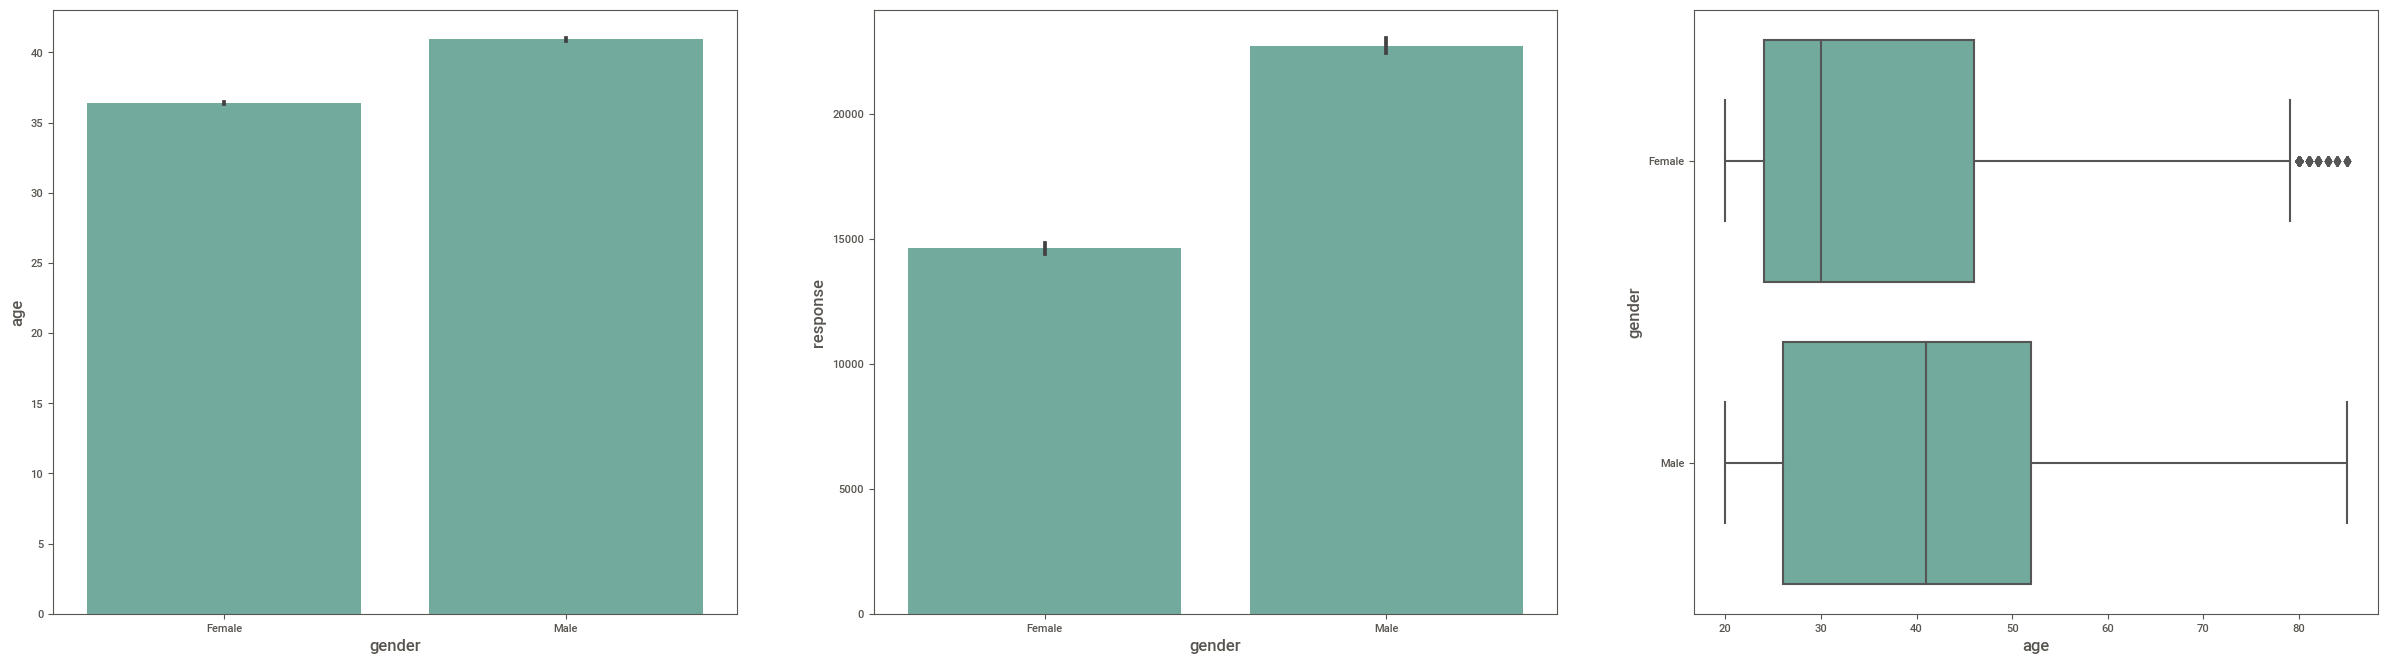

In [87]:
plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
sns.barplot(x='gender', y='age', data=df4, color= '#69b3a2');

plt.subplot(1,3,2)
sns.barplot(x='gender', y='response', data=df4, color='#69b3a2',estimator=sum);

plt.subplot(1,3,3)
sns.boxplot(x='age', y='gender', data=df4, color= '#69b3a2');

### Columns age

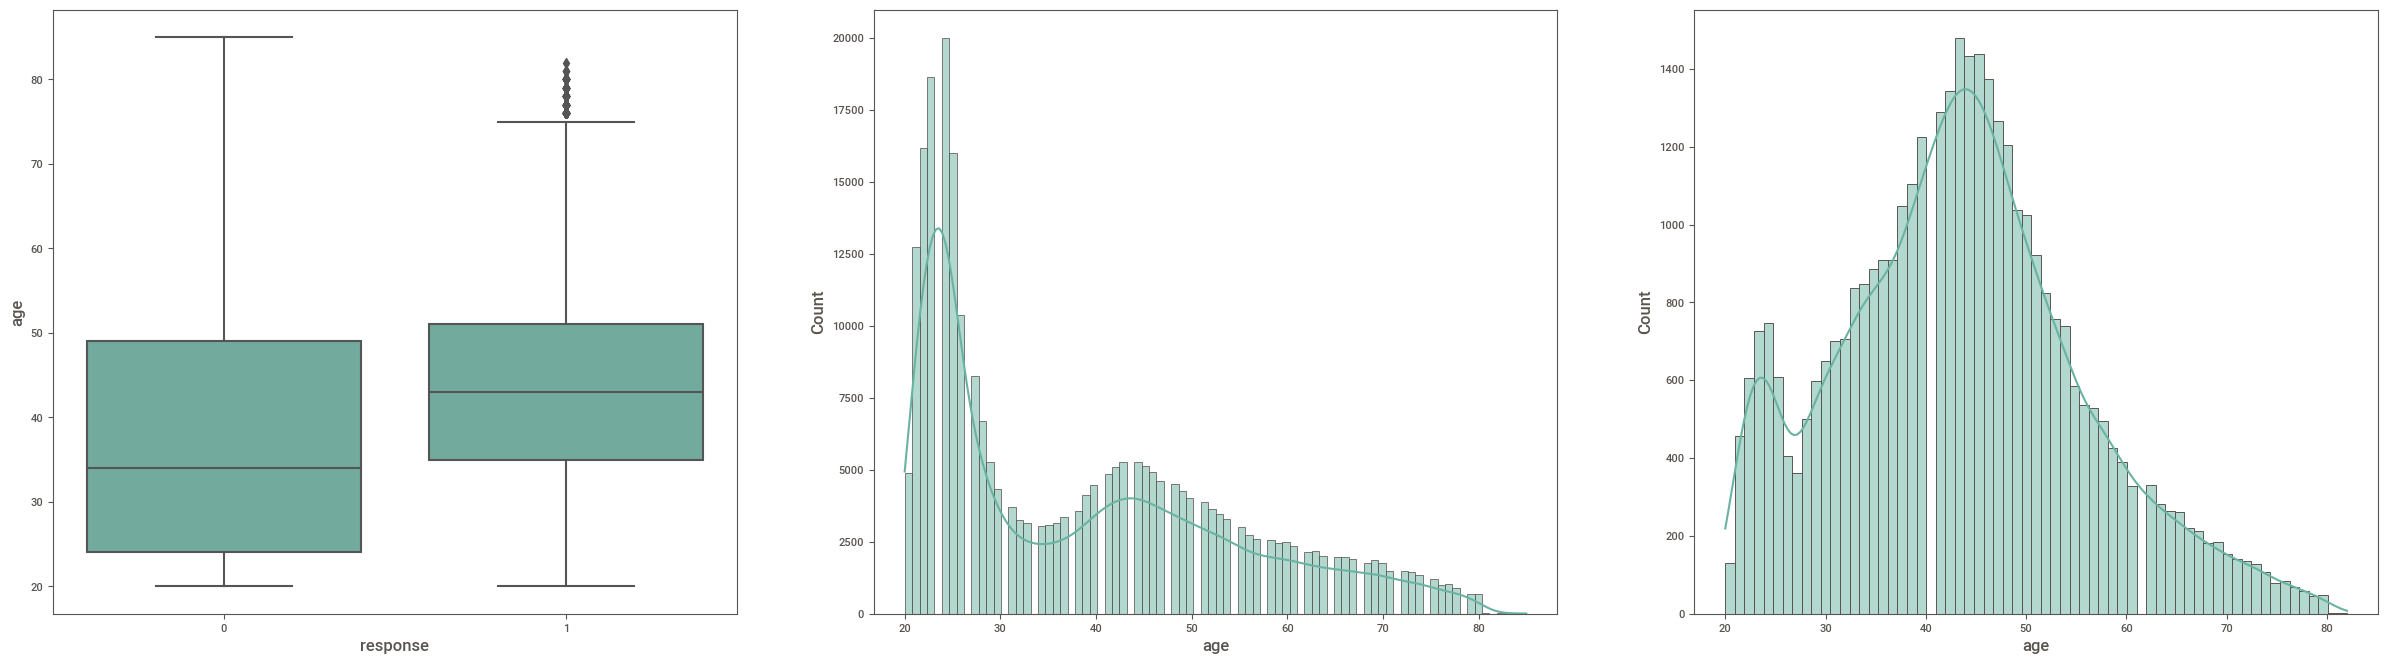

In [88]:

plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
sns.boxplot(x='response', y='age', data=df4, color= '#69b3a2')


plt.subplot(1,3,2)
sns.histplot(df4.loc[df4['response'] == 0, 'age'], kde=True, color='#69b3a2')

plt.subplot(1,3,3)
sns.histplot(df4.loc[df4['response'] == 1, 'age'], kde=True, color='#69b3a2');

* Temos para a classe 0, onde são os clientes que não tiveram interesse no seguro de automovel na pesquisa uma mediana de 35 anos, onde temos o primeiro quartil de 20 a 35 anos, para os clientes que tiveram interesse no novo produto temos uma mediana de 40 anos, neste caso podemos notar que temos uma mediana deslocada, Temos clases bem desbalanceada, pois são 25k clientes que não tem interesse e apenas 1750 com interese.

* Conclusão inicial para esta variavel que pessoas mais novas não tem interresse no seguro.

### Columns region_code	

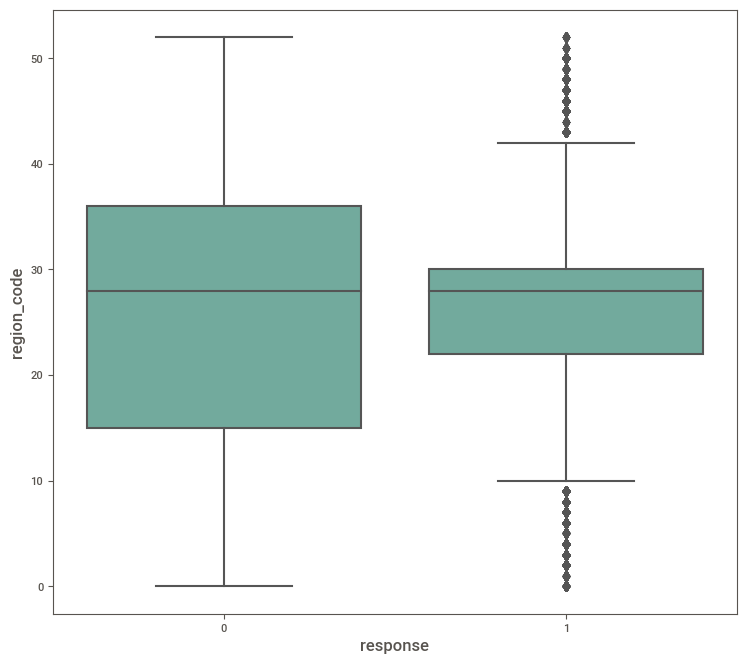

In [89]:
aux0= df4[['id', 'region_code', 'response','previously_insured']].groupby(['id','region_code', 'response', 'previously_insured']).count().reset_index()

plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
sns.boxplot(x='response', y='region_code', data=aux0, color= '#69b3a2');

Temos essa variavel bem equilibrada entre os interessados e não interessados, onde temos uma concentração muito grande em cima da região 28, não sabemos exatamente de qual seria essa região, pois não fica especificado no conjunto de dados. A conclusão dessa coluna é que não explica muita coisa em relação ao modelo. 

### Columns policy_sales_channel

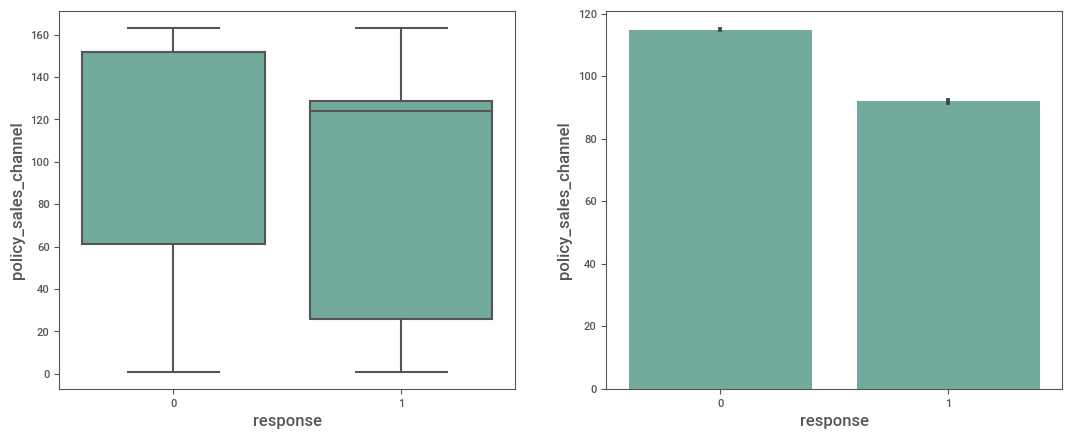

In [90]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3 , 1)
sns.boxplot(y=df4['policy_sales_channel'], x=df4['response'], color= '#69b3a2');

plt.subplot(1, 3 , 2)
sns.barplot(y=df4['policy_sales_channel'], x=df4['response'], color= '#69b3a2');

### Columns driving_license

   response  driving_license  driving_license_perc
0         0           266912              0.877307
1         1            37328              0.122693


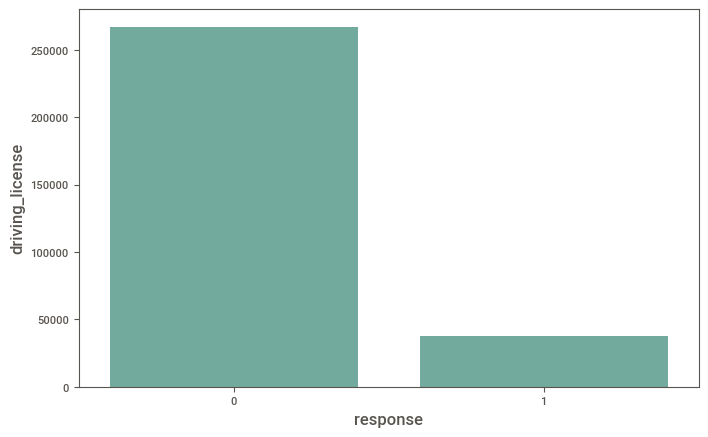

In [91]:
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
print(aux)

plt.figure(figsize=(8, 5))
sns.barplot(x='response', y='driving_license', data=aux, color='#69b3a2');


In [92]:
pd.crosstab(df4['response'], df4['driving_license'],margins=False)

driving_license,0,1
response,,
0,612,266912
1,35,37328


Analise dessa features, tras um resultado que quase 90% das pessoas que tem habilitação não tem interesse no seguro e menos de 13% tem habilitação e tem interesse no produto.

### Column vehicle_age

In [93]:
df4.vehicle_age.value_counts(normalize=True)

beetween_1_1_year    0.526008
below_1_year         0.431934
over_2_year          0.042058
Name: vehicle_age, dtype: float64

### Column vehicle_damage

   response  vehicle_damage  vehicle_damage_perc
0         0          117583             0.762719
1         1           36580             0.237281


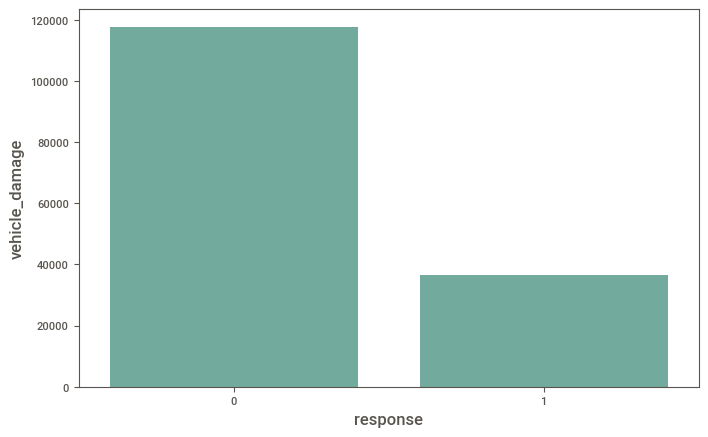

In [94]:
aux1 = df4[['vehicle_damage', 'response']].groupby('response').sum().reset_index()
aux1['vehicle_damage_perc'] = aux1['vehicle_damage'] / aux1['vehicle_damage'].sum()
print(aux1)

plt.figure(figsize=(8, 5))
sns.barplot(x='response', y='vehicle_damage', data=aux1, color='#69b3a2');

In [95]:
pd.crosstab(df4['response'], df4['vehicle_damage'],margins=False)

vehicle_damage,0,1
response,,
0,149941,117583
1,783,36580


Nessa features, conclui que temos muito mais pessoas que ja teve algum tivo de sinistro que não tem interesse no seguro, representando quase 80% da base.

### column previously_insured

   response  previously_insured  previously_insured_perc
0         0              139374                 0.999054
1         1                 132                 0.000946


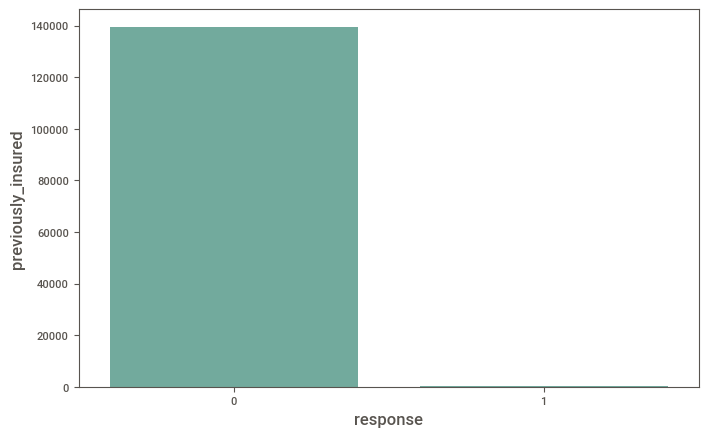

In [96]:
aux2 = df4[['previously_insured', 'response']].groupby('response').sum().reset_index()
aux2['previously_insured_perc'] = aux2['previously_insured'] / aux2['previously_insured'].sum()
print(aux2)

plt.figure(figsize=(8, 5))
sns.barplot(x='response', y='previously_insured', data=aux2, color='#69b3a2');

In [97]:
pd.crosstab(df4['response'], df4['previously_insured'],margins=False)

previously_insured,0,1
response,,
0,128150,139374
1,37231,132


Para as pessoas que tem interesse no seguro quase 100% ja esta assegurada com um outro seguro de automovel, temos uma diferença maior para pessoas que não teve interesse na pesquisa, fazendo mais sentido pessoas que não tem seguro tambem não teria interesse no nosso produto.

### Column annual_premium

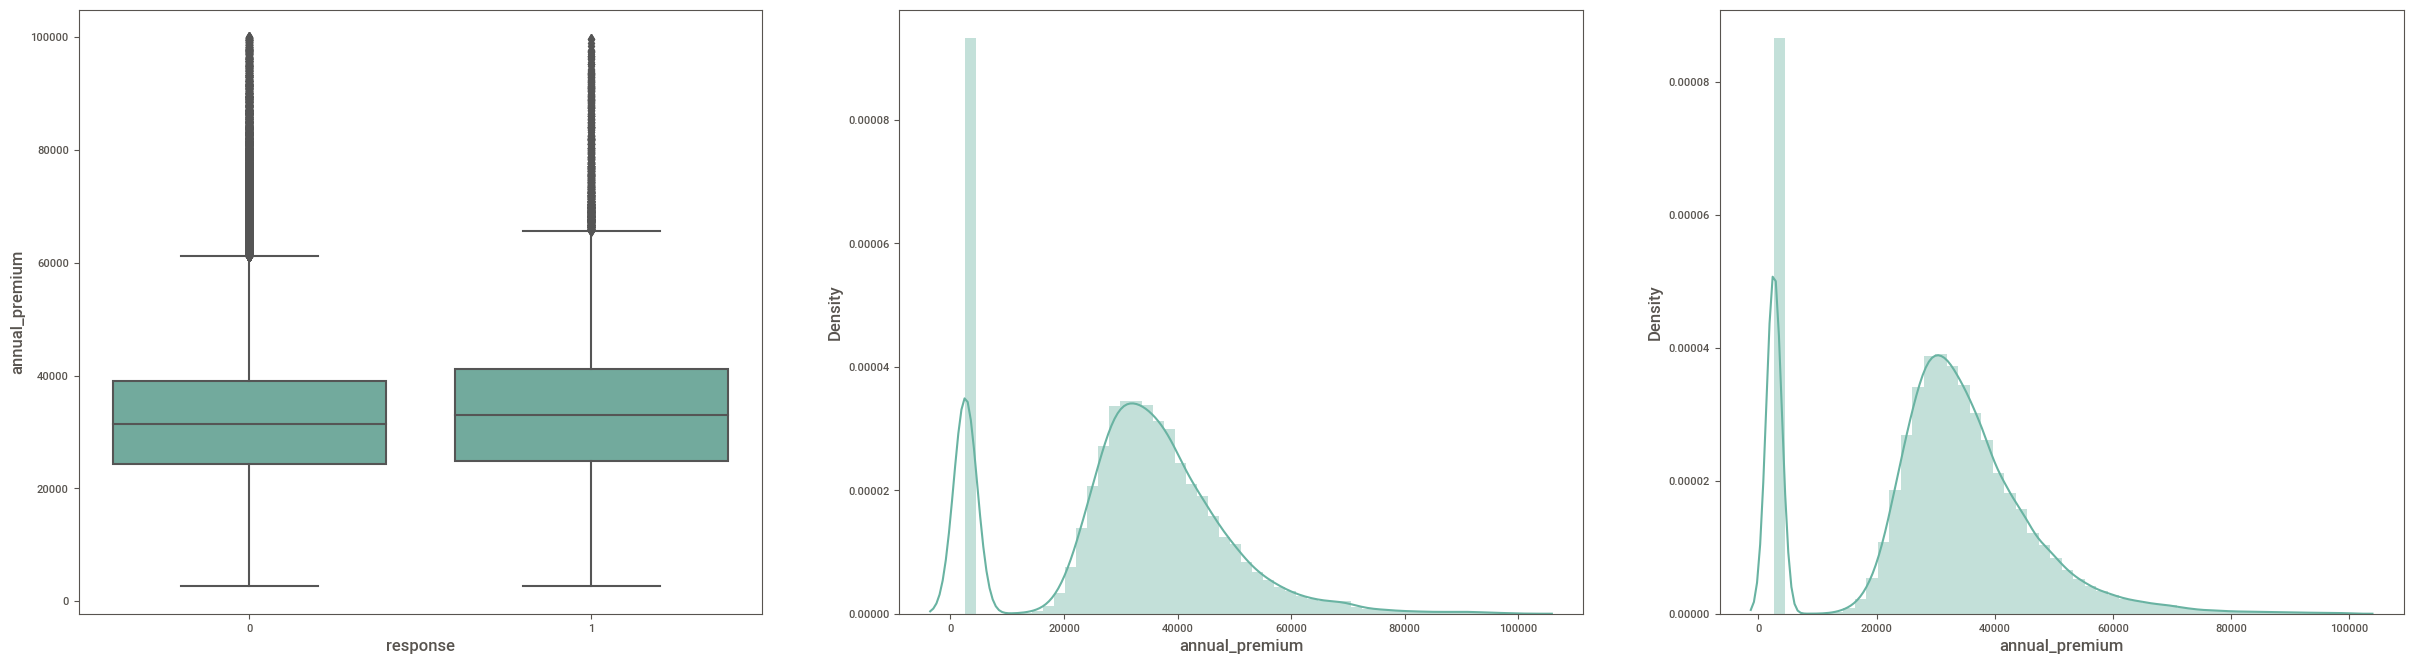

In [98]:
aux3 = df3[['annual_premium', 'response']]

aux4 = aux3[aux3['annual_premium'] < 100000]

plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
sns.boxplot(x='response', y='annual_premium', data=aux4, color= '#69b3a2');

aux5 = aux4[aux3['response'] == 1]
plt.subplot(1,3,2)
sns.distplot(aux5['annual_premium'], color= '#69b3a2');

aux6 = aux4[aux3['response'] == 0]
plt.subplot(1,3,3)
sns.distplot(aux6['annual_premium'], color= '#69b3a2');





### Column Vintage

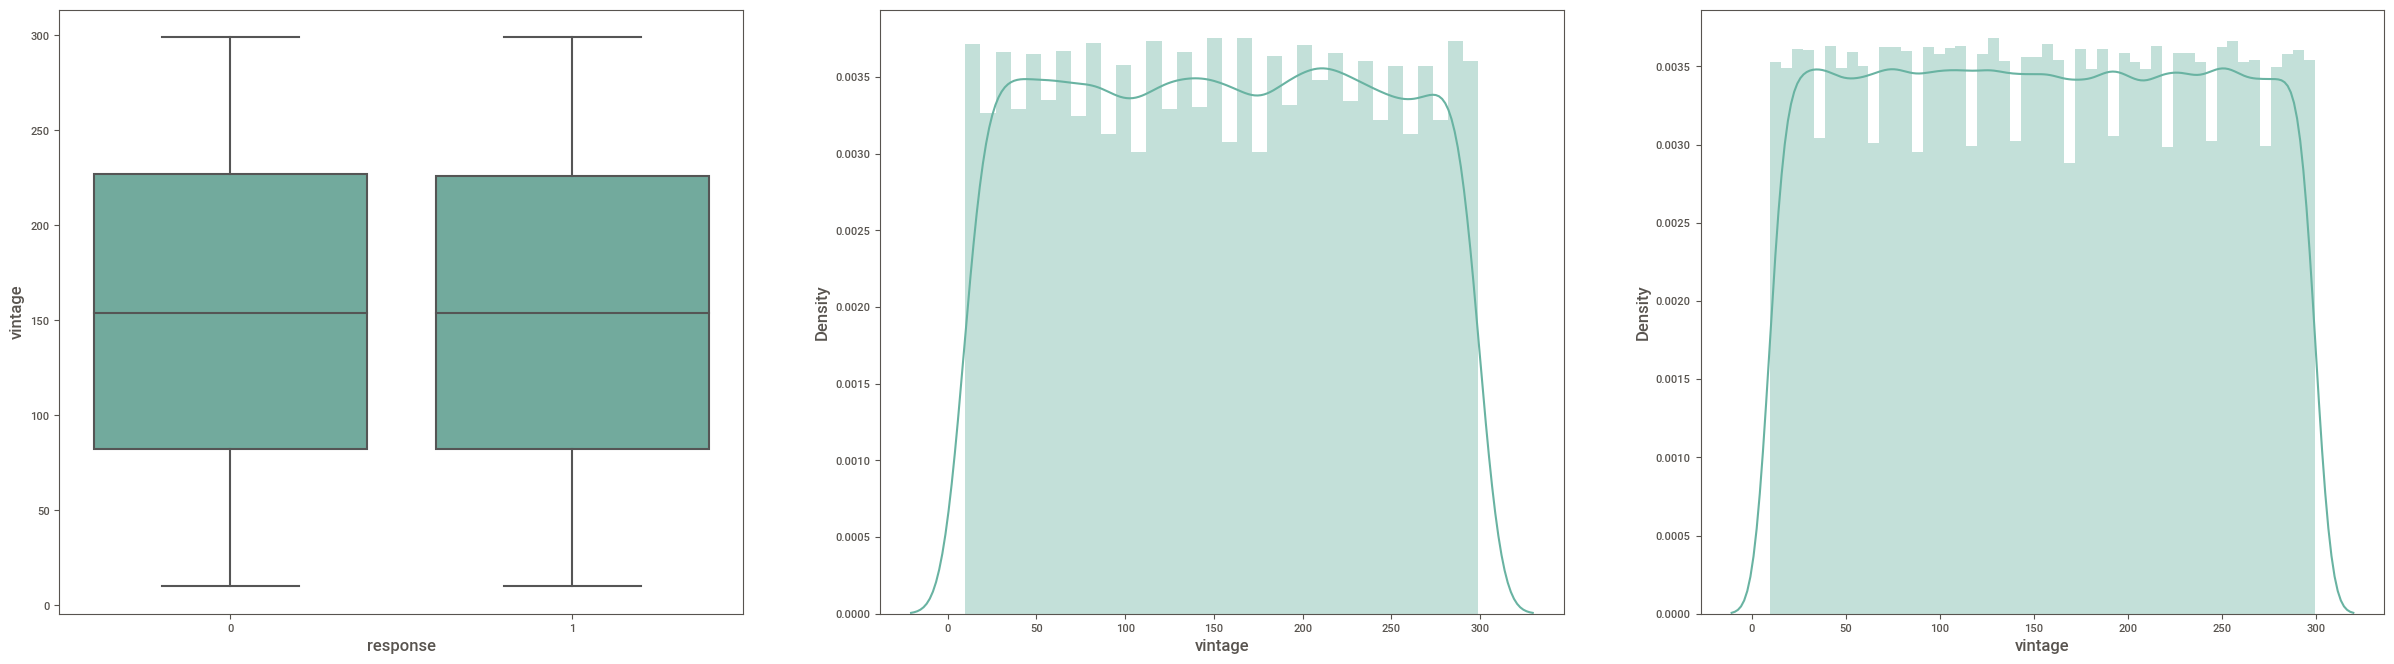

In [99]:
aux7 = df4[['vintage', 'response']]

plt.figure(figsize=(30, 8))

plt.subplot(1,3,1)
sns.boxplot(x='response', y='vintage', data=aux7, color= '#69b3a2');

aux8 = aux7[aux7['response'] == 1]
plt.subplot(1,3,2)
sns.distplot(aux8['vintage'], color= '#69b3a2');

aux9 = aux7[aux7['response'] == 0]
plt.subplot(1,3,3)
sns.distplot(aux9['vintage'], color= '#69b3a2');


Variaveis praticamente iguais. Não diz nada.

## Bivariate Analysis

Aqui, as hipóteses criadas anteriormente serão validadas e serão gerados Insights sobre os atributos mais relevantes dos clientes interessados em adquirir o seguro do veículo.

In [100]:
df4.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,21908,Female,22,22.0,152.0,1,below_1_year,1,0,41632.0,87,0
1,84580,Male,22,2.0,152.0,1,below_1_year,1,0,2630.0,147,0
2,223179,Male,66,28.0,124.0,1,beetween_1_1_year,0,1,34524.0,216,0
3,224406,Female,23,23.0,160.0,1,below_1_year,0,1,2630.0,280,0
4,296599,Male,54,28.0,26.0,1,beetween_1_1_year,0,1,64831.0,64,0


**H1,** 50% dos clientes com mais de 40 anos aceitariam o seguro de carro.

Hipotese Falsa, apenas 17.19% dos clientes acima de 40 anos aceitariam fazer um seguro de veiculos


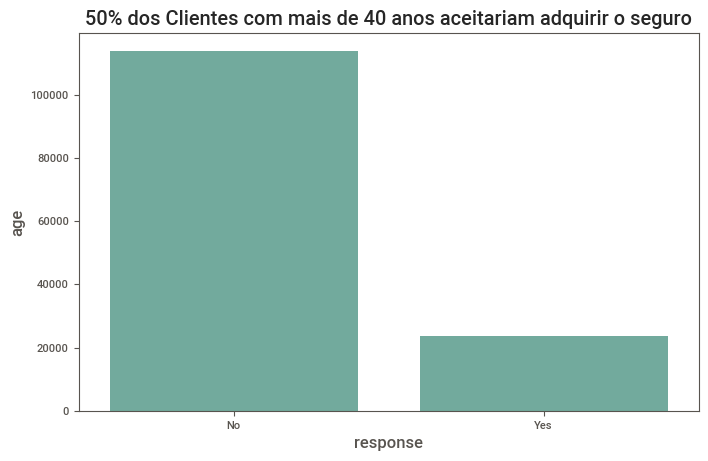

In [101]:
aux10 = df4[df4['age'] >= 40][['age', 'response']].groupby('response').count().reset_index()

perc = (aux10['age'][1] / aux10['age'].sum()) * 100
print('Hipotese Falsa, apenas {:.2f}% dos clientes acima de 40 anos aceitariam fazer um seguro de veiculos'.format(perc))

plt.subplots(figsize=(8, 5))

fig10 = sns.barplot(aux10['response'], aux10['age'], color='#69b3a2')
fig10.set_title('50% dos Clientes com mais de 40 anos aceitariam adquirir o seguro')
fig10.set_xticklabels(['No', 'Yes']);

**H2,** 80% Dos clientes são do sexo Masculino



Hipotese falsa,pois de todos os clientes da empresa, 54.05% são do sexo masculino


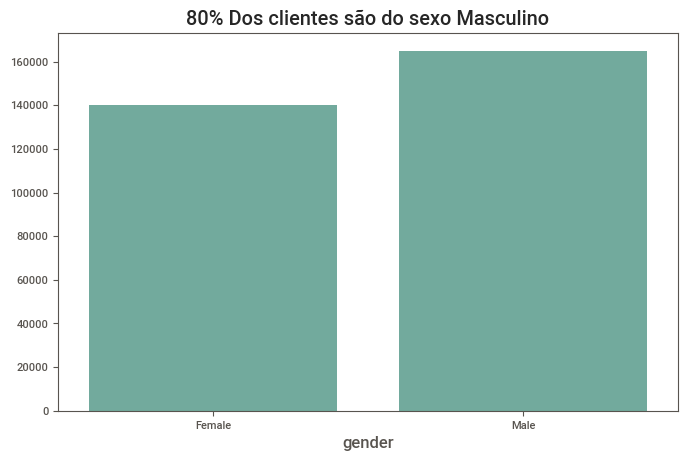

In [102]:
aux11 = df4.groupby('gender')['gender'].count()

perc1 = round((aux11[1] / (aux11[0] + aux11[1]))* 100 ,2) 

plt.subplots(figsize=(8, 5))

fig11 = sns.barplot(aux11.index, aux11.values, color='#69b3a2')
fig11.set_title('80% Dos clientes são do sexo Masculino');

print('Hipotese falsa,pois de todos os clientes da empresa, {:.2f}% são do sexo masculino'.format(perc1))

In [103]:
aux11

gender
Female    140094
Male      164793
Name: gender, dtype: int64

**H3,** 80% dos clientes Habilitados são do sexo Masculino.



Hipotese falsa,pois de todos os clientes da empresa habilitado, 54.01% são do sexo masculino


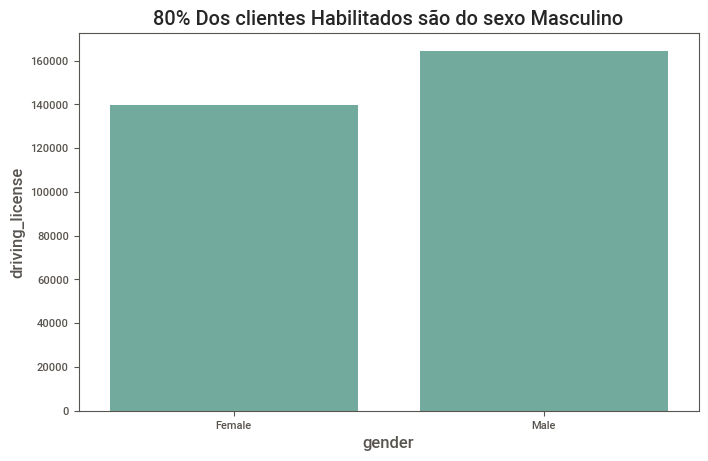

In [104]:
aux12 = df4[df4['driving_license'] == 1][['gender', 'driving_license']].groupby('gender').sum().reset_index()

perc12 = (aux12['driving_license'][1] / aux12['driving_license'].sum()) * 100


plt.subplots(figsize=(8, 5))

fig12 = sns.barplot(aux12.gender, aux12.driving_license, color='#69b3a2')
fig12.set_title('80% Dos clientes Habilitados são do sexo Masculino');

print('Hipotese falsa,pois de todos os clientes da empresa habilitado, {:.2f}% são do sexo masculino'.format(perc12))

**H4,** 80% Dos clientes que teve o carro danificado são do sexo masculino. 



Hipotese falsa,pois de todos os clientes da empresa que ja teve seu veiculo danificado, 58.53% são do sexo masculino.


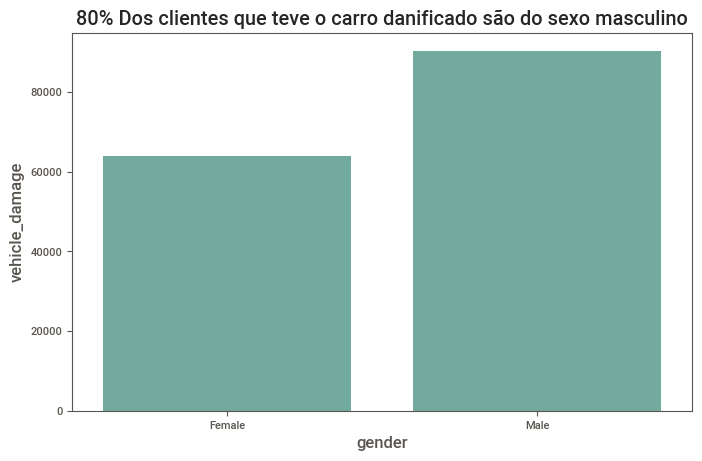

In [105]:
aux13 = df4[df4['vehicle_damage'] == 1][['gender','vehicle_damage' ]].groupby('gender').sum().reset_index()

perc13 =  (aux13['vehicle_damage'][1] / aux13['vehicle_damage'].sum()) * 100

plt.subplots(figsize=(8, 5))

fig13 = sns.barplot(aux13.gender, aux13.vehicle_damage, color='#69b3a2');
fig13.set_title('80% Dos clientes que teve o carro danificado são do sexo masculino');

print('Hipotese falsa,pois de todos os clientes da empresa que ja teve seu veiculo danificado, {:.2f}% são do sexo masculino.'.format(perc13))

**H5,** Clientes acima de 40 anos tem carros mais antigos, acima de 2 anos



Hipotese falsa, apenas 8.76% dos clientes acima de 40 anos tem veiculo com idade acima de 2 anos.


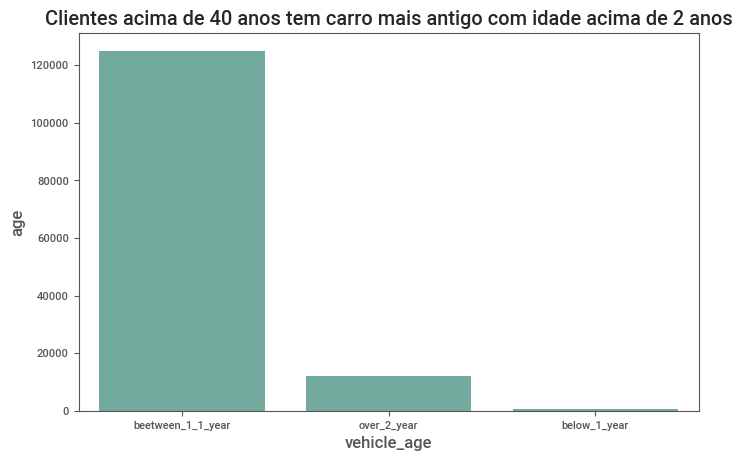

In [106]:
aux14 = df4[df4['age'] >= 40][['vehicle_age','age']].groupby('vehicle_age').count().sort_values(by= 'age',ascending=False).reset_index()

perc14 = (aux14['age'][1] / aux14['age'].sum()) * 100

plt.subplots(figsize=(8, 5))

fig14 = sns.barplot(aux14.vehicle_age, aux14.age, color='#69b3a2');
fig14.set_title('Clientes acima de 40 anos tem carro mais antigo com idade acima de 2 anos');

print('Hipotese falsa, apenas {:.2f}% dos clientes acima de 40 anos tem veiculo com idade acima de 2 anos.'.format(perc14))

**H6,** Na media 20% dos Clientes que ja são assegurado aceitaria adquirir um novo seguro.



Hipotese Falsa, apenas %0.09 dos clientes que ja tem seguro aceitaria um novo seguro


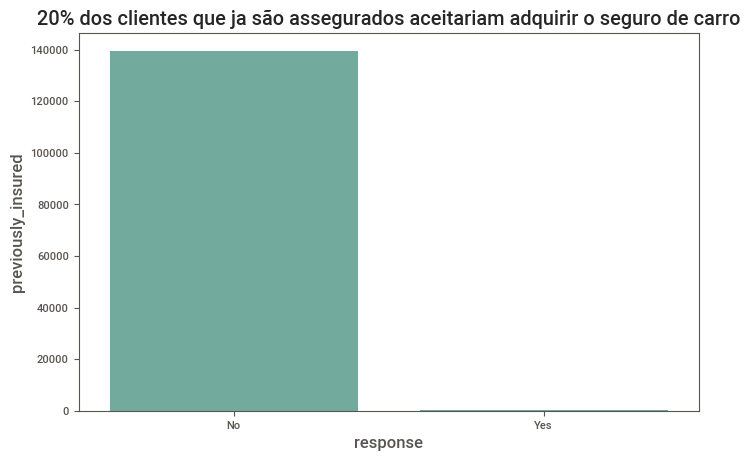

In [107]:
aux15 = df4[df4['previously_insured'] == 1][['previously_insured', 'response']].groupby('response').sum().reset_index()

perc15 = (aux15['previously_insured'][1] / aux15['previously_insured'].sum()) * 100

plt.subplots(figsize=(8, 5))

fig15 = sns.barplot(aux15.response, aux15.previously_insured, color='#69b3a2')
fig15.set_title('20% dos clientes que ja são assegurados aceitariam adquirir o seguro de carro');
fig15.set_xticklabels(['No', 'Yes'])

print('Hipotese Falsa, apenas %{:.2f} dos clientes que ja tem seguro aceitaria um novo seguro'.format(perc15))

**H7,** 70% dos Clientes que pagam acima de 30000 pelo premium do seguro de saude aceitariam adquirir o seguro de automovel



Hipotese Falsa, apenas %0.13 dos clientes que possui um valor anual acima de 30000 teria interesse em um novo seguro veicular


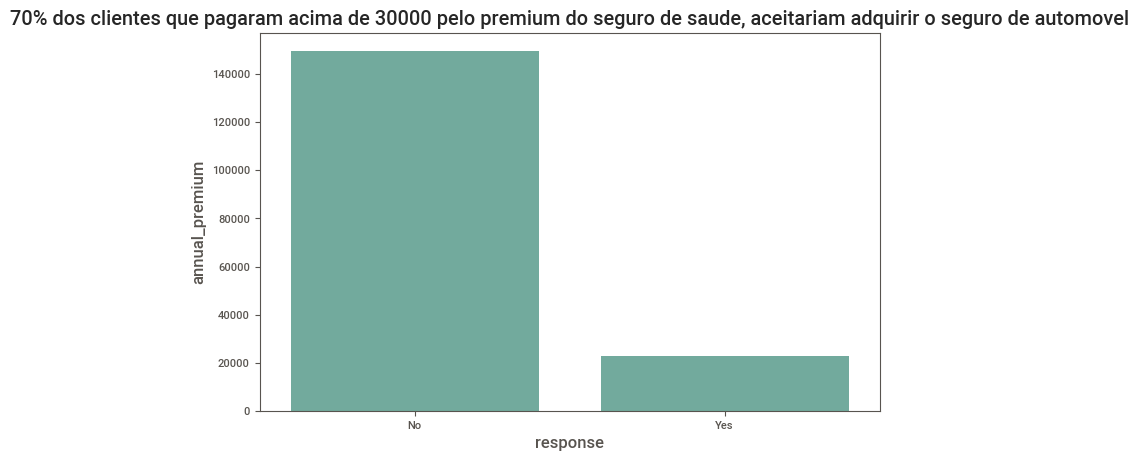

In [108]:
aux16 = df4[df4['annual_premium'] > 30000][['annual_premium', 'response']].groupby('response').count().reset_index()

perc16 = aux16['annual_premium'][1] / aux16['annual_premium'].sum()

plt.subplots(figsize=(8, 5))

fig16 = sns.barplot(aux16.response, aux16.annual_premium, color='#69b3a2')
fig16.set_xticklabels(['No', 'Yes'])
fig16.set_title('70% dos clientes que pagaram acima de 30000 pelo premium do seguro de saude, aceitariam adquirir o seguro de automovel');

print('Hipotese Falsa, apenas %{:.2f} dos clientes que possui um valor anual acima de 30000 teria interesse em um novo seguro veicular'.format(perc16))


**H8,** 60% dos Clientes que danificou o carro colocou na pesquisa que tem interesse em adquirir o seguro.



Hipotese Falsa, apenas %23.73 dos clientes que danificou o veiculo, teria interesse em um novo seguro veicular


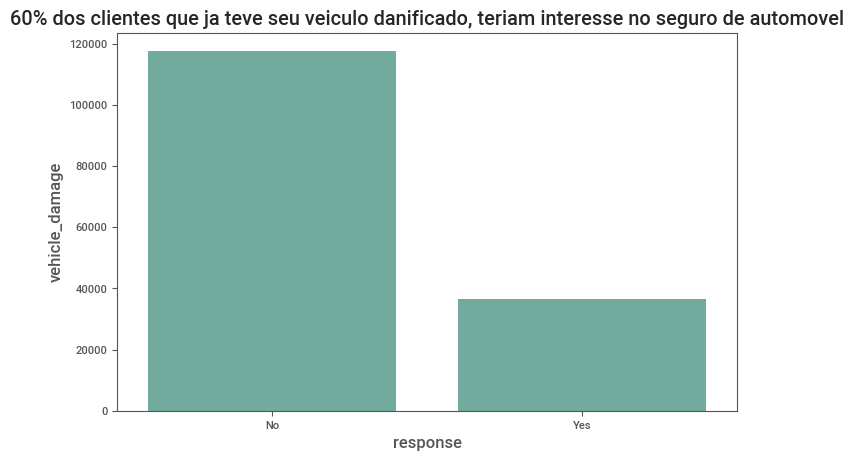

In [109]:
aux17 = df4[df4['vehicle_damage'] == 1][['vehicle_damage', 'response']].groupby('response').count().reset_index()

perc17 = aux17['vehicle_damage'][1] / aux17['vehicle_damage'].sum() * 100

plt.subplots(figsize=(8, 5))

fig17 = sns.barplot(aux17.response, aux17.vehicle_damage, color='#69b3a2')
fig17.set_xticklabels(['No', 'Yes'])
fig17.set_title('60% dos clientes que ja teve seu veiculo danificado, teriam interesse no seguro de automovel')

print('Hipotese Falsa, apenas %{:.2f} dos clientes que danificou o veiculo, teria interesse em um novo seguro veicular'.format(perc17))

**H9,** 20% dos Clientes com veiculo acima de 2 anos de idade teria interesse no seguro segundo a pesquisa.

Hipotese Verdadeira, %29.21 dos clientes que teria veiculo com idade acima de 2 anos, teria interesse em um novo seguro veicular


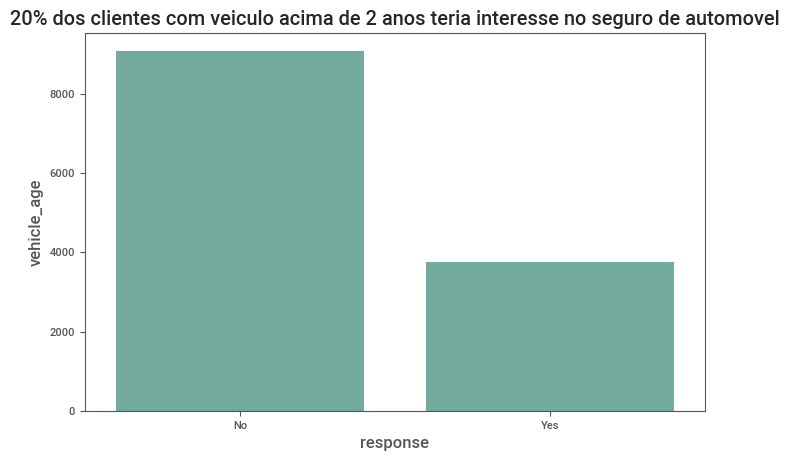

In [110]:
aux18 = df4[df4['vehicle_age'] == 'over_2_year'][['vehicle_age', 'response']].groupby('response').count().reset_index()

perc18 = aux18['vehicle_age'][1] / aux18['vehicle_age'].sum() * 100

plt.subplots(figsize=(8, 5))

fig18 = sns.barplot(aux18.response, aux18.vehicle_age, color='#69b3a2')
fig18.set_xticklabels(['No', 'Yes'])
fig18.set_title('20% dos clientes com veiculo acima de 2 anos teria interesse no seguro de automovel')

print('Hipotese Verdadeira, %{:.2f} dos clientes que teria veiculo com idade acima de 2 anos, teria interesse em um novo seguro veicular'.format(perc18))

### Resumo das Hipoteses

In [111]:
h1 = '50% dos clientes com mais de 40 anos aceitariam o seguro de carro.'
h2 = '80% Dos clientes são do sexo Masculino'
h3 = '80% dos clientes Habilitados são do sexo Masculino.'
h4 = '80% Dos clientes que teve o carro danificado são do sexo masculino.'
h5 = 'Clientes acima de 40 anos tem carros mais antigos, acima de 2 anos'
h6 = 'Na media 20% dos Clientes que ja são assegurado aceitaria adquirir um novo seguro.'
h7 = '70% dos Clientes que pagam acima de 30000 pelo premium do seguro de saude aceitariam adquirir o seguro de automovel'
h8 = '60% dos Clientes que danificou o carro colocou na pesquisa que tem interesse em adquirir o seguro'
h9 = '20% dos Clientes com veiculo acima de 2 anos de idade teria interesse no seguro segundo a pesquisa.'


In [112]:
tab= [
    ['Hipotese', 'Conclusao'],
    [h1, 'Falsa', ],
    [h2, 'Falsa'],
    [h3, 'Falsa'],
    [h4, 'Falsa'],
    [h5, 'Falsa'],
    [h6, 'Falsa'],
    [h7, 'Falsa'],
    [h8, 'Falsa'],
    [h9, "falsa"]



]

print(tabulate(tab, headers='firstrow'))

Hipotese                                                                                                             Conclusao
-------------------------------------------------------------------------------------------------------------------  -----------
50% dos clientes com mais de 40 anos aceitariam o seguro de carro.                                                   Falsa
80% Dos clientes são do sexo Masculino                                                                               Falsa
80% dos clientes Habilitados são do sexo Masculino.                                                                  Falsa
80% Dos clientes que teve o carro danificado são do sexo masculino.                                                  Falsa
Clientes acima de 40 anos tem carros mais antigos, acima de 2 anos                                                   Falsa
Na media 20% dos Clientes que ja são assegurado aceitaria adquirir um novo seguro.                                   Falsa
70% do

# 5 - Data Preparation

In [113]:
path_model = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/health-insurance-cross-sell.pa04/models/'
path_data = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/health-insurance-cross-sell.pa04/data/'

In [114]:
df5 = pd.read_csv('/home/wellington/Documentos/Projetos/Projetos_ds_pa/health-insurance-cross-sell.pa04/data/df4_Feature_Engineering.csv', index_col=0)

df5.head(3)

,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
id,,,,,,,,,,,
21908,Female,22,22.0,152.0,1,below_1_year,1,0,41632.0,87,0
84580,Male,22,2.0,152.0,1,below_1_year,1,0,2630.0,147,0
223179,Male,66,28.0,124.0,1,beetween_1_1_year,0,1,34524.0,216,0


### Standardization

#### Para variaveis numericas com distribuição normal

Coluna 'annual_premium' Vamos padroniza neste ciclo do Crisp.

In [115]:
stand = pp.StandardScaler()

df5['annual_premium'] = stand.fit_transform(df5[['annual_premium']].values)
pickle.dump (stand, open (path_model+'health_annual_paid_scaler.pkl', 'wb') )

### Rescaling

#### Para Variaveis numericas com distribuição NÃO normal.

In [116]:
mms_age = pp.MinMaxScaler()
mms_vintage= pp.MinMaxScaler()

#Age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open(path_model+'age_scaler.pkl', 'wb'))

#Vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open(path_model+'vintage_mms.pkl', 'wb'))

### Encoder

#### Transforme variáveis categóricas em numéricas.

##### Algumas variáveis já estão codificadas (0 e 1): Driving_license, Vehicle_prev_insured, Vehicle_damage

In [117]:


#gender
target_encoder_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encoder_gender)
pickle.dump(target_encoder_gender, open(path_model+'target_encoder_gender.pkl', 'wb'))

#Region_Code
target_encoder_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encoder_region_code)
pickle.dump(target_encoder_region_code, open(path_model+'target_encoder_region_code.pkl', 'wb'))

#vehicle_age
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])


#policy_sales_channel - 
freq_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(freq_policy_sales_channel)
pickle.dump(freq_policy_sales_channel, open(path_model+'freq_policy_sales_channel.pkl', 'wb'))

In [118]:
#Conjunto de dados do treinamento preparado
df5.head()

,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,response,vehicle_age_beetween_1_1_year,vehicle_age_below_1_year,vehicle_age_over_2_year
id,,,,,,,,,,,,,
21908,0.104423,0.030769,0.065476,0.353393,1,1,0,0.643197,0.266436,0,0,1,0
84580,0.137955,0.030769,0.070607,0.353393,1,1,0,-1.626590,0.474048,0,0,1,0
223179,0.137955,0.707692,0.186997,0.194741,1,0,1,0.229535,0.712803,0,1,0,0
224406,0.104423,0.046154,0.154639,0.057172,1,0,1,-1.626590,0.934256,0,0,1,0
296599,0.137955,0.523077,0.186997,0.208858,1,0,1,1.993302,0.186851,0,1,0,0


## Test Preparation

Replicando as transformações feita em treino(df5) para o conjunto de dados x_test.

In [119]:
#Carregando meus dados de teste
df_test = pd.read_csv('/home/wellington/Documentos/Projetos/Projetos_ds_pa/health-insurance-cross-sell.pa04/data/test_full_data.csv')

In [120]:
x_test = df_test
y_test = x_test['response']
x_test = x_test.drop('response', axis=1)


In [121]:
x_test

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage
0,121273,Male,26,18.0,160.0,1,< 1 Year,Yes,0,2630.0,279
1,71972,Female,54,39.0,26.0,1,1-2 Year,No,1,38931.0,71
2,166693,Male,50,15.0,26.0,1,1-2 Year,No,0,33901.0,164
3,38231,Male,35,28.0,154.0,1,1-2 Year,Yes,0,37714.0,22
4,61549,Male,24,46.0,152.0,1,< 1 Year,No,1,19688.0,219
...,...,...,...,...,...,...,...,...,...,...,...
76217,252301,Female,28,8.0,152.0,1,< 1 Year,Yes,0,38722.0,130
76218,227434,Male,27,28.0,156.0,1,1-2 Year,Yes,0,52215.0,130
76219,71358,Male,75,41.0,26.0,1,1-2 Year,Yes,0,37161.0,96
76220,301724,Male,50,50.0,122.0,1,1-2 Year,No,1,43651.0,92


In [122]:
y_test

0        0
1        0
2        0
3        1
4        0
        ..
76217    0
76218    0
76219    0
76220    0
76221    0
Name: response, Length: 76222, dtype: int64

### Standardization

In [123]:
x_test['annual_premium'] = stand.fit_transform(x_test[['annual_premium']].values)

### Rescaling

In [124]:
#Age
x_test['age'] = mms_age.fit_transform(x_test[['age']].values)

#Vintage
x_test['vintage'] = mms_vintage.fit_transform(x_test[['vintage']].values)

### Encoder

In [125]:
#vehicle_damage
x_test['vehicle_damage'] = x_test['vehicle_damage'].map(dict_vehicle_damage)

#gender

x_test.loc[:, 'gender'] = x_test['gender'].map(target_encoder_gender)

#Region_Code

x_test.loc[:, 'region_code'] = x_test['region_code'].map(target_encoder_region_code)

#vehicle_age
x_test = pd.get_dummies(x_test, prefix='vehicle_age', columns=['vehicle_age'])

#policy_sales_channel - 

x_test.loc[:, 'policy_sales_channel'] = x_test['policy_sales_channel'].map(freq_policy_sales_channel)


#### Verificando se o conjunto de dados x_test esta preparado, igual aos dados de Treinamento(df5), exceto variavel resposta(Response). 

In [126]:
x_test.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
0,121273,0.137955,0.093750,0.133864,0.057172,1,1,0,-1.608096,0.930796,0,1,0
1,71972,0.104423,0.531250,0.126555,0.208858,1,0,1,0.486285,0.211073,1,0,0
2,166693,0.137955,0.468750,0.071846,0.208858,1,0,0,0.196080,0.532872,1,0,0
3,38231,0.137955,0.234375,0.186997,0.015701,1,1,0,0.416070,0.041522,1,0,0
4,61549,0.137955,0.062500,0.103189,0.353393,1,0,1,-0.623937,0.723183,0,1,0


In [127]:
df5.head()

,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,response,vehicle_age_beetween_1_1_year,vehicle_age_below_1_year,vehicle_age_over_2_year
id,,,,,,,,,,,,,
21908,0.104423,0.030769,0.065476,0.353393,1,1,0,0.643197,0.266436,0,0,1,0
84580,0.137955,0.030769,0.070607,0.353393,1,1,0,-1.626590,0.474048,0,0,1,0
223179,0.137955,0.707692,0.186997,0.194741,1,0,1,0.229535,0.712803,0,1,0,0
224406,0.104423,0.046154,0.154639,0.057172,1,0,1,-1.626590,0.934256,0,0,1,0
296599,0.137955,0.523077,0.186997,0.208858,1,0,1,1.993302,0.186851,0,1,0,0


In [128]:
#Check NA

x_test.isna().sum()

id                       0
gender                   0
age                      0
region_code              0
policy_sales_channel     3
driving_license          0
vehicle_damage           0
previously_insured       0
annual_premium           0
vintage                  0
vehicle_age_1-2 Year     0
vehicle_age_< 1 Year     0
vehicle_age_> 2 Years    0
dtype: int64

In [129]:
x_test.loc[x_test['policy_sales_channel'].isna()]

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years
19238,70882,0.137955,0.609375,0.070607,NaN,1,0,1,-0.129088,0.200692,1,0,0
24455,214962,0.104423,0.531250,0.096190,NaN,1,1,0,0.344990,0.197232,1,0,0
55264,314461,0.104423,0.312500,0.096190,NaN,1,0,1,4.254106,0.982699,1,0,0


In [130]:
y_test = y_test.drop([19238, 24455, 55264])

In [131]:
y_test.count()

76219

In [132]:
# Remove these indexes on x_test
x_test = x_test.drop(index = [19238,24455,55264] )

x_test.shape

(76219, 13)

In [134]:
print('Check NA:')
x_test.isna().sum()

Check NA:


id                       0
gender                   0
age                      0
region_code              0
policy_sales_channel     0
driving_license          0
vehicle_damage           0
previously_insured       0
annual_premium           0
vintage                  0
vehicle_age_1-2 Year     0
vehicle_age_< 1 Year     0
vehicle_age_> 2 Years    0
dtype: int64

In [135]:
#Exportando dados de treino preparado
df5.to_csv(path_data+'df5_data_preparado_done.csv') #contem x_train + y_train

#Exportando dados de teste preparado
x_test.to_csv(path_data+'x_test.csv') #x_test
y_test.to_csv(path_data+'y_test.csv') #y_test

# 6 - Feature Selection

In [136]:
df6 = pd.read_csv(path_data+'df5_data_preparado_done.csv')
df6.head(1)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,response,vehicle_age_beetween_1_1_year,vehicle_age_below_1_year,vehicle_age_over_2_year
0,21908,0.104423,0.030769,0.065476,0.353393,1,1,0,0.643197,0.266436,0,0,1,0


#### Executando uma nova divisão de dados, utilizando agora o df6 = df5_data_preparado_done.

In [137]:
X = df6.drop(['response', 'id'], axis=1).copy()
y = df6['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, stratify=y, test_size=0.10, random_state=42)

In [138]:
#check split
print('x_train -> ',x_train.shape)
print('y_train -> ',y_train.shape)
print('x_val -> ',x_val.shape)
print('y_val -> ',y_val.shape)

x_train ->  (274398, 12)
y_train ->  (274398,)
x_val ->  (30489, 12)
y_val ->  (30489,)


### Extra Trees

##### Vamos usar Extra Trees para encontrar a importância dos recursos. Pode ser um Boruta, Random Forest, XGBoost, etc

In [139]:
#Model Definition
trees = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

In [140]:
#data Preparation
x_train_n = x_train
y_train_n = y_train.values

trees.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:
                         feature  importance
0                        vintage    0.271756
0                 annual_premium    0.243062
0                            age    0.167121
0                    region_code    0.105544
0                 vehicle_damage    0.067673
0           policy_sales_channel    0.060573
0             previously_insured    0.056531
0       vehicle_age_below_1_year    0.012295
0  vehicle_age_beetween_1_1_year    0.007248
0                         gender    0.005193
0        vehicle_age_over_2_year    0.002514
0                driving_license    0.000490


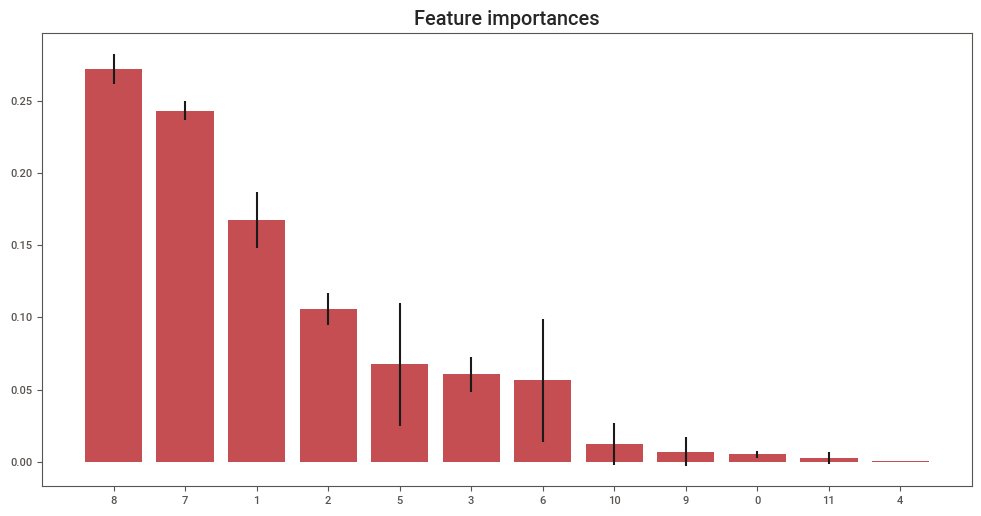

In [141]:
importances = trees.feature_importances_
std = np.std( [tree.feature_importances_ for tree in trees.estimators_], axis=0 )
indices = np.argsort(importances)[::-1] #trees importance ordered by greater value

# Print feature ranking
print('Feature Ranking:')
df_imp = pd.DataFrame()
for i, j in zip( x_train_n, trees.feature_importances_ ):
    aux = pd.DataFrame( {'feature':i , 'importance': j}, index=[0] )
    df_imp = pd.concat( [df_imp, aux], axis=0 )
    
print(df_imp.sort_values('importance', ascending=False) )

# Plot the imputity-based feature importances of the forest
plt.figure()
plt.title('Feature importances')
plt.bar( range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center' )
plt.xticks( range(x_train_n.shape[1]), indices )
plt.xlim( [-1, x_train_n.shape[1]] )
plt.show()

A característica mais relevante do ET (vintage) com 27% de relevância.

Por outro lado, Vehicle_age parece irrelevante (1% para Vehicle_age_below_1_year ).

Vamos selecionar os 7 principais recursos mais importantes do E.T. neste ciclo Crisp, e verificar o desempenho do modelo com eles.

In [142]:
columns = ['vintage', 'annual_premium', 'age', 'region_code',
       'vehicle_damage', 'policy_sales_channel', 'previously_insured']

#Novo data com as colunas selecionada pelo modelo
x_train = x_train[columns]
x_val = x_val[columns]

In [143]:
x_train.head()

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured
90194,0.543253,-0.118656,0.138462,0.122144,0,0.353393,1
102177,0.301038,0.403077,0.184615,0.096190,0,0.208858,1
218776,0.622837,-1.626590,0.015385,0.069519,1,0.057172,0
15088,0.543253,-0.295341,0.030769,0.103189,0,0.353393,1
136119,0.858131,-1.626590,0.169231,0.098138,1,0.353393,0


In [144]:
x_val.head()

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured
285336,0.923875,0.238031,0.246154,0.110915,0,0.353393,1
148260,0.730104,-1.626590,0.046154,0.122144,1,0.208858,0
203263,0.456747,0.648376,0.030769,0.088147,1,0.353393,0
251513,0.920415,0.612993,0.076923,0.128282,0,0.353393,1
222850,0.802768,-0.188201,0.446154,0.157211,1,0.015701,0


In [145]:
#Exportando o treinamento com as novas colunas selecionada
x_train.to_csv(path_data+'x_train.csv') #x_test
y_train.to_csv(path_data+'y_train.csv') #y_test

#Exportando a validação com as novas colunas selecionada
x_val.to_csv(path_data+'x_val.csv') #x_test
y_val.to_csv(path_data+'y_val.csv') #y_test